### Introduction to statistics
**Homework:** Problem 6a. Deadline for submission: **January 27, midnight**. 

**Problem 6a (German tank problem).** During WW2, the Allies discovered that German tanks carry consecutive serial numbers. Given a small collection of serial numbers of tanks that were captured or destroyed, they attempted to estimate the total number of tanks produced, and with great effect.

Formally, we a given a sample $X_1,\ldots,X_n$ from a uniform distribution over $\{1,\ldots,M\}$ and we want to estimate $M$. One obvious unbiased estimator is $$\hat{M}_1 = \frac{\sum_{i=1}^n X_i}{n} \cdot 2 - 1.$$
However, there are other options, notably $$\hat{M}_2 = \max\{X_1,\ldots,X_n\} \cdot \frac{n+1}{n}-1.$$

In this problem, your goal is to:
 * Verify empirically that the second estimator is indeed unbiased (this will also be proved formally in the class).
 * Decide which of the two estimators is more effective (has lower variance).
 
**Note:** For the second estimator to be unbiased, the sampling has to be without replacement. This is also more realistic in the tank problem context.

**Hints:**

   * Use `rd.choice` and `np.arange` for sampling without replacement
   * To estimate the variances, sample 1000 samples per N tanks (choose your own N). Store your results in a 1000xN matrix.
   * The function `np.sum` has a keyword `axis`, which controls over which axis you sum. In particular, `np.sum(X, 1)` will return the sums of rows. 

**Problem 6b (Testing a sampler).** In this problem we will attempt to check whether the sampler we created in **Problem 2c** works correctly. To this end we will use a chi-squared goodness-of-fit test. This test works as follows:
 * Let $p_1,\ldots,p_d$ be the date frequencies as in the text file, scaled down to sum up to 1.
 * Use the sampler to generate a sample of dates. Let $c_1,\ldots,c_d$ be the observed counts, and let $f_i=Np_i$ be the expected counts, where $N$ is the sample size. 
 * Compute the test statistic $$S = \sum_{i=1}^d \frac{\left(c_i-f_i\right)^2}{f_i}.$$
 * Our base assumption (the null hypothesis) $H_0$ is that our sampler works correctly. If $H_0$ is true AND if the expected count for each bucket is large enough, then $S$ has (approximately) a $\chi^2$ distribution with $d-1$ degrees of freedom. 
 * Look up how likely is getting an $S$ value as large as the one you obtained if it has that distribution, i.e. the $p$-value. To do this use **scipy.stats.chi2.cdf**. If this value turns out small, then it means that we have observed an effect which should not take place under $H_0$. This means that we have grounds to reject $H_0$. Otherwise we do not reject, but this does not mean $H_0$ is proved! 
 * Verify your results by running the test using the function `scipy.stats.chisquare(c, f)`, which performs the test.
 * We mentioned earlier that expected counts for the buckets need to be large enough. "Large enough" assumption here is used to guarantee that $c_i$ are distributed approximately normally. Typically one requires that all counts are at least $5$. This is not the case in our problem (unless we take a huge sample) because of the errors in the data. The typical approach is to glue several buckets into one but this does not help in our case. Instead, ignore the erroneous dates when computing $c_i$ and $f_i$ and run the test again (on the same sample!). Remember to use a different number of degrees of freedom. Compare the results.
 
**Hints:**

* The function `plt.hist()` returns, amongst others, the numbers of elements in bins. Alternatively, you can use `np.bincount()`.

* Note that when you compute the test, you need to use the counts $f_i$, not the frequencies $p_i$. 

* A rule-of-thumb is that we reject $H_0$ when p-value is less than 0.05.

The code from Lab 2, using the histogram squaring method:

In [4]:
import numpy as np
import numpy.random as rd
import scipy.stats as ss  # this one will be used later
from matplotlib import pyplot as plt

def empDates4(p, N):
    """
    Sample distances between repeated dates using histogram squaring method. 
    p: a vector with numbers of births in i-th day
    N: number of days to sample 
    """
    n = len(p)
    s = np.sum(p)
    
    # Tworzymy kubełki i wrzucamy do nich unormowane p 
    M = 1 / n
    V = p / s  # Uwaga: p musi być macierzą numpy, a nie listą, żeby to działało!
    eps = 1e-6  # Epsilonowy próg zapełnienia kubełka - potrzebny ze względu na precyzję arytmetyki 
    
    # Losujemy dni
    index2 = np.zeros(n)  # Indeks drugiego p_i w danym kubełku (w każdym są dwa)
    threshold = np.ones(n) # Proporcja zawartości p_i z oryginalnego indeksu w kubełku
    while True:  # główna pętla algorytmu
        over, under = 0, 0  # Indeksy pierwszego przepełnionego i pierwszego niepełnego kubełka
        while under < n and V[under] >= M-eps:  # Szukamy niepełnego kubełka
            under += 1
        if under == n:  # Jeśli doszliśmy do końca, to wszystkie są wypełnione 
            break  # Wychodzimy z głównej pętli
        while V[over] <= M: # Szukamy przepełnionego kubełka. W tym momencie wiemy że istnieje.
            over += 1
        # Przypisujemy indeks kubełka z którego przelewamy
        index2[under] = over 
        # Zapisujemy proporcję pola kubełka under zapełnionego przez oryginalne p_i przed przelaniem. 
        threshold[under] = V[under]/M
        # Przelewamy prawdopodobieństwo
        V[over] = V[over] - M + V[under]
        V[under] = M
    
    # W tym momencie mamy gotowe kubełki, zapisane w threshold oraz index2.
    days = rd.randint(0, n, N) # Losujemy kubełki
    alternative = index2[days] # Tworzymy wektor kodujący sparowane kubełki 
    thr = threshold[days]  # Wyciągamy wektor złożony z wartości threshold odpowiadających wylosowanym dniom
    low = rd.uniform(0, 1, N) # Losujemy N zmiennych o rozkładzie ciągłym jednostajnym na odcinku [0, 1]
    low = low <= thr  # Tworzymy wektor boolowski; Na i-tej współrzędnej True jeśli low[i] <= thr[i] 
    # Jeśli low[i] == True, to bierzemy oryginalny kubełek; Jeśli False, to bierzemy kubełek z index2.
    days = np.where(low, days, alternative) 
    
    # W tym momencie mamy wylosowane dni urodzin. Wcześniej obliczaliśmy odległości pomiędzy powtórzeniami, 
    # ale teraz zależy nam na dniach 
#     s = set()
#     k = 0
#     sample = []
#     for d in days:  # Iterujemy po wylosowanych dniach
#         k += 1  # Zwiększamy liczbę kroków
#         if d in s:
#             sample.append(k)  # Dodajemy obliczoną liczbę kroków do wyniku
#             s = set()  # Resetujemy zbiór
#             k = 0  # Resetujemy liczbę kroków
#         else:
#             s.add(d)
#    return sample 
    return days

The code for visual comparison of distributions:

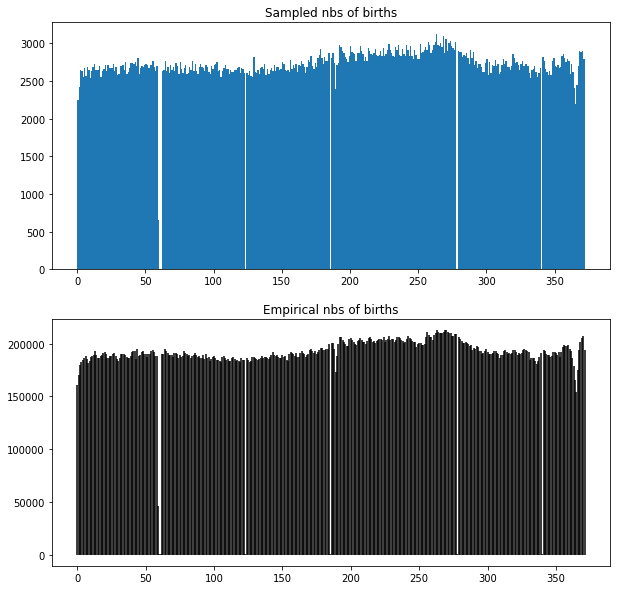

In [7]:
stats = np.loadtxt('us_births_69_88.csv',skiprows=1,delimiter=',',dtype=int)

ndays = stats.shape[0]
births = stats[:,2]

sample_size = 1000000
sample = empDates4(births, sample_size)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.hist(sample, bins=np.arange(0, ndays+1, 1))
plt.title("Sampled nbs of births")
plt.subplot(2, 1, 2)
plt.vlines(np.arange(0, ndays, 1), 0, births)
plt.title("Empirical nbs of births")
plt.show()

** Problem 6c (Chi-square independence test).** 
Let’s consider a hypothetical case where we test the effectiveness of a drug for a certain medical condition.

Suppose we have 105 patients under study and 50 of them were treated with the drug. The remaining 55 patients were kept as control samples and treated with a placebo. The health condition of all patients was checked after a week.

The following table shows if their condition improved or not. Just by looking at it, can you tell if the drug had a positive effect on the patients compared to the placebo? Are you sure that the improvement is not just a random effect?

\begin{array}{ccc}
& \hbox{Improved} & \hbox{Not improved}  \\
\hbox{Treated} &  32  & 18 \\
\hbox{Not treated} & 26 & 29  \\
\end{array}

To check if an effect is real, and not just random, we run a chi-squared test of independence. It's very similar to the chi-squared test of goodness of fit, so be careful not to get confused with the details!

To perform a chi-square test of independence, given a so-called *contingency table* $X$ with counts, like the one above:
 * Compute row totals $r_i$, column totals $c_j$, and overall total $N$.
 * If the variables are independent, we expect to see $f_{ij} = N \cdot (r_i c_j / N^2) = r_i c_j /N$ elements in $i$-th row $j$-th column.
 * Compute the test statistic as before, i.e. $$ S = \sum_{ij} \frac{\left(f_{ij}-X_{ij}\right)^2}{f_{ij}}.$$
 * Again test vs $\chi^2$ CDF. In this test, if the variables are independent, we have $(r-1)\cdot (c-1)$ degrees of freedom, where $r$ is the *number of rows* and $c$ is the *number of columns* (not the number of observations!)
 * Compare your results with the built-in test `scipy.stats.chi2_contingency(X, correction=False)`.
 
**Hints:**

* For two vectors $a, b$, a matrix $c = [a_i\cdot b_j]_{i, j}$ is called a *tensor product* of $a$ and $b$. You can compute it in numpy by typing `np.tensordot(a, b, axes=0)`.

**Problem 6d (two-sample t-test).** We have two versions of a randomized optimization algorithm. In the table below you can find the objective function values for $n=20$ solutions found by each algorithm. Our goal is to decide if one of the algorithms is better than the other (i.e. finds solutions with higher values). We can proceed as follows:
 * Compute the means $M_1,M_2$. We need to decide if the difference $M_1-M_2$ is significant.
 * We estimate the standard deviation of $M_1-M_2$. Show that this is equal to $\sqrt{n(\sigma_1^2+\sigma_2^2)}$, where $\sigma_1^2$ and $\sigma_2^2$. We can estimate this by $D=\sqrt{n(\hat{\sigma_1^2}+\hat{\sigma_2^2})}$ where $\hat{\sigma_i^2}$ is an unbiased estimate of the variance of $i$-th algorithm.
 * Now compute $\frac{M_1-M_2}{D}$. If the real values of $\sigma_i$ are equal, i.e. $\sigma_1=\sigma_2$, then this has a $t$-distribution with $2n-2$ degrees of freedom. 
 * Use **scipy.stats.t.cdf** to compute the p-value and decide if we can reject the null hyphotesis of the means being equal. Note that in our case the probability of getting a difference "at least as large as the one we got" has to include deviations in both directions!
 
Below, you have sample results from the two hypothetical algorithms:

In [298]:
data=np.array([ [98.67573, 100.77983, 101.35478,  98.50285,  99.14984, 
      100.64105,  98.37170, 100.24933, 99.54994, 100.79508, 
      101.14978, 101.32538, 100.44573, 97.60020, 97.78547,  
      98.88703,  99.06794, 100.65313, 100.30297, 100.26311],
       [99.96234, 99.94943, 99.58779, 100.52263, 101.58972,
        101.78411, 100.09874, 100.99211, 101.93214, 100.61749,
        100.46854,  99.19030, 101.28412, 100.70897, 99.83988,
        100.24668,  99.38278,  99.82720,  97.55918, 100.63128]])